In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install tbats

     |████████████████████████████████| 51kB 2.0MB/s 
     |████████████████████████████████| 1.1MB 10.0MB/s 


In [0]:
import pandas as pd # 데이터 전처리
import numpy as np # 데이터 전처리
import matplotlib.pyplot as plt # 데이터 시각화
import itertools
from datetime import datetime, timedelta # 시간 데이터 처리
from tbats import TBATS, BATS 
from time import time
import datetime

In [0]:
test = pd.read_csv("/content/drive/My Drive/dacon/df_hour_1118.csv")
test = test.round(4)
submission = pd.read_csv("/content/drive/My Drive/dacon/submission.csv")

In [0]:
#test =test.iloc[-24*30*4-6*24:]
test=test.iloc[-24*30*2-24*3:]

In [0]:
test['Time'] = pd.to_datetime(test['Time']) 
X_test = test.iloc[-168:-144].reset_index()
test = test.iloc[:-168]

In [0]:
# 상가로 추측되는 여름 데이터
kk_c1= ['Time','X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X73', 'X67', 'X91', 'X87', 'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82', 'X80', 'X102', 'X70', 'X75', 'X107']
# 상가로 추측되는 봄 데이터
kk_c2= ['Time','X26', 'X16', 'X7', 'X18', 'X41', 'X55', 'X5', 'X43', 'X59', 'X10', 'X62', 'X61', 'X32', 'X31', 'X30', 'X51', 'X35', 'X44', 'X37', 'X42', 'X50', 'X47', 'X20']
# 아파트로 추측되는 데이터
kk_n = ['Time','X303', 'X241', 'X435', 'X402', 'X352', 'X305', 'X350', 'X326', 'X299', 'X160', 'X211', 'X349', 'X407', 'X330', 'X132', 'X231', 'X225', 'X286', 'X354', 'X353', 'X255', 'X393', 'X157', 
          'X323', 'X130', 'X269', 'X172', 'X289', 'X216', 'X398', 'X233', 'X214', 'X270', 'X371', 'X200', 'X163', 'X364', 'X378', 'X271', 'X462', 'X427', 'X263', 'X450', 'X206', 'X133', 'X195', 'X134', 
          'X297', 'X175', 'X254', 'X196', 'X412', 'X337', 'X406', 'X414', 'X260', 'X252', 'X455', 'X320', 'X276', 'X423', 'X218', 'X399', 'X213', 'X379', 'X468', 'X253', 'X247', 'X262', 'X248', 'X357', 
        'X215', 'X177', 'X228', 'X187', 'X245', 'X242', 'X376', 'X166', 'X472', 'X275', 'X313', 'X201', 'X408', 'X419', 'X460', 'X367', 'X143', 'X312', 'X410', 'X389', 'X300', 'X470', 'X445', 'X158', 
        'X421', 'X178', 'X308', 'X217', 'X229', 'X358', 'X148', 'X397', 'X363', 'X165', 'X296', 'X219', 'X431', 'X302', 'X314', 'X405', 'X315', 'X176', 'X396', 'X449', 'X383', 'X473', 'X205', 'X161', 
        'X403', 'X341', 'X149', 'X377', 'X232', 'X333', 'X140', 'X422', 'X386', 'X250', 'X142', 'X235', 'X446', 'X331', 'X186', 'X243', 'X194', 'X183', 'X139', 'X459', 'X457', 'X368', 'X282', 'X426', 
        'X192', 'X283', 'X329', 'X223', 'X266', 'X443', 'X347', 'X230', 'X155','X481']

In [0]:
test_c1 = pd.concat([test[kk_c1].iloc[:1394], test[kk_c1].iloc[3467:]]).reset_index().drop('index',axis=1)
test_c2 = test[kk_c2]
test_n = test[kk_n]

In [0]:
test_c1 = test_c1.set_index('Time')
test_c2 = test_c2.set_index('Time')
test_n = test_n.set_index('Time')

In [0]:
def new_df(data):
    place_id=[]; time=[] ; target=[] # 빈 리스트를 생성합니다.
    for i in data.columns:
        for j in range(len(data)):
            place_id.append(i) # place_id에 미터 ID를 정리합니다.
            time.append(data.index[j]) # time에 시간대를 정리합니다.
            target.append(data[i].iloc[j]) # target에 전력량을 정리합니다.

    new_df=pd.DataFrame({'place_id':place_id,'time':time,'target':target})
    new_df=new_df.dropna() # 결측치를 제거합니다.
    new_df=new_df.set_index('time') # time을 인덱스로 저장합니다.
    
    return new_df

In [0]:
sun1 = new_df(test_c1)
sun2 = new_df(test_c2)
sun3 = new_df(test_n)

predict

In [0]:
from time import time

total_start_time = time()

agg={}
sun1 =sun1.astype({'target':'float64'})
for key in sun1['place_id'].unique(): # 미터ID 200개의 리스트를 unique()함수를 통해 추출합니다.
    temp = sun1.loc[sun1['place_id']==key].reset_index() # 미터ID 하나를 할당합니다.

    a = pd.DataFrame() # a라는 데이터프레임에 예측값을 정리합니다
    start_time = time()
# 시간별 예측

    estimator = TBATS(
        seasonal_periods=(24, 168),
        use_arma_errors=True,  # shall try models with and without ARMA
        use_box_cox=True,  # will not use Box-Cox
        use_trend=True,  # will try models with trend and without it
        use_damped_trend=None,  # will try models with daming and without it
        show_warnings=False ) # will not be showing any warnings for chosen model

    model = estimator.fit(temp['target'])

    # Forecast 24 hours ahead 
    fcst = model.forecast(steps=24)
    
    for i in range(24):
        a['X2018_7_1_'+str(i+1)+'h']=[fcst[i]] # column명을 submission 형태에 맞게 지정합니다.
        a['X2018_7_1_'+str(i+1)+'h'] = np.where(a['X2018_7_1_'+str(i+1)+'h']<0, temp['target'].min(), a['X2018_7_1_'+str(i+1)+'h']) # 음수는 최소값으로 대체

    # 그래프
    plt.plot(range(0,24),a[a.columns[0:24]].iloc[0], label='pred')
    plt.plot(range(0,24),X_test[key],label='target')
    plt.legend()
    plt.xlabel('hour')
    plt.title(key)
    plt.show()
    
    for i in range(10):
        a['X2018_7_'+str(i+1)+'_d']= 0
    
    # 월별 예측
    # 일별로 예측하여 7월 ~ 11월의 일 수에 맞게 나누어 합산합니다.
    a['X2018_7_m'] = 0 # 7월 
    a['X2018_8_m'] = 0 # 8월
    a['X2018_9_m'] = 0 # 9월
    a['X2018_10_m'] = 0 # 10월
    a['X2018_11_m'] = 0 # 11월
    
    a['meter_id'] = key 
    agg[key] = a[submission.columns.tolist()]
    print(key)

    print('finished in {}'.format(str(datetime.timedelta(seconds=time() - start_time))))
print('complited in {}'.format(str(datetime.timedelta(seconds=time() - total_start_time))))
print('---- Modeling Done ----')

In [0]:
TBATS_11 = pd.concat(agg, ignore_index=False)
TBATS_12 = TBATS_11.reset_index().drop(['level_0','level_1'], axis=1)
TBATS_12['id'] = TBATS_12['meter_id'].str.replace('X','').astype(int)
TBATS_12 =  TBATS_12.sort_values(by='id', ascending=True).drop(['id'], axis=1).reset_index(drop=True)

In [0]:
from time import time

total_start_time = time()

agg={}
for key in sun2['place_id'].unique(): # 미터ID 200개의 리스트를 unique()함수를 통해 추출합니다.
    temp = sun2.loc[sun2['place_id']==key] # 미터ID 하나를 할당합니다.

    a = pd.DataFrame() # a라는 데이터프레임에 예측값을 정리합니다
    start_time = time()
# 시간별 예측

    estimator = TBATS(seasonal_periods=(24, 168))
    model = estimator.fit(temp['target'])
    # Forecast 24 hours ahead 
    fcst = model.forecast(steps=24)
    
    for i in range(24):
        a['X2018_7_1_'+str(i+1)+'h']=[fcst[i]] # column명을 submission 형태에 맞게 지정합니다.
        a['X2018_7_1_'+str(i+1)+'h'] = np.where(a['X2018_7_1_'+str(i+1)+'h']<0, temp['target'].min(), a['X2018_7_1_'+str(i+1)+'h'])

    # 그래프
    plt.plot(range(0,24),a[a.columns[0:24]].iloc[0], label='pred')
    plt.plot(range(0,24),X_test[key],label='target')
    plt.legend()
    plt.title(key)
    plt.show()
    
    for i in range(10):
        a['X2018_7_'+str(i+1)+'_d']= 0
    
    # 월별 예측
    # 일별로 예측하여 7월 ~ 11월의 일 수에 맞게 나누어 합산합니다.
    a['X2018_7_m'] = 0 # 7월 
    a['X2018_8_m'] = 0 # 8월
    a['X2018_9_m'] = 0 # 9월
    a['X2018_10_m'] = 0 # 10월
    a['X2018_11_m'] = 0 # 11월
    
    a['meter_id'] = key 
    agg[key] = a[submission.columns.tolist()]
    print(key)

    #print(key, ' : ',results_ARIMA.aic, ' , ')
    print('finished in {}'.format(str(datetime.timedelta(seconds=time() - start_time))))
print('complited in {}'.format(str(datetime.timedelta(seconds=time() - total_start_time))))
print('---- Modeling Done ----')

In [0]:

TBATS_21 = pd.concat(agg, ignore_index=False)
TBATS_22 = TBATS_21.reset_index().drop(['level_0','level_1'], axis=1)
TBATS_22['id'] = TBATS_22['meter_id'].str.replace('X','').astype(int)
TBATS_22 =  TBATS_22.sort_values(by='id', ascending=True).drop(['id'], axis=1).reset_index(drop=True)

In [0]:
results = pd.concat([TBATS_11,TBATS_21],axis=0)
results['id'] = results['meter_id'].str.replace('X','').astype(int)
results = results.sort_values(by='id', ascending=True).drop(['id'], axis=1).reset_index(drop=True)

In [0]:
results.to_csv('/content/drive/My Drive/dacon/Tbats_c1c2.csv', index=False)

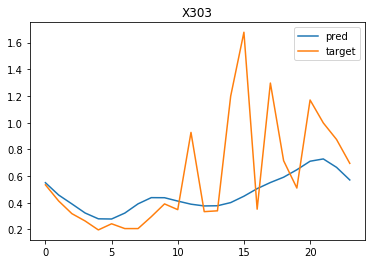

X303
finished in 0:07:37.600684


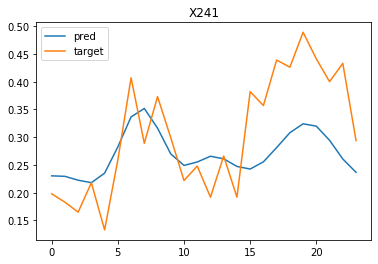

X241
finished in 0:11:10.699939


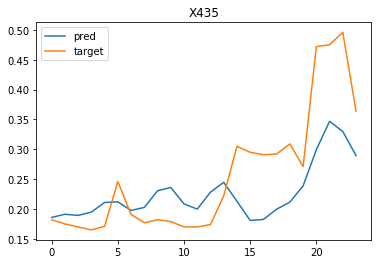

X435
finished in 0:06:55.335091


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/pyt

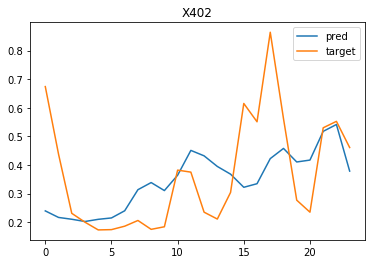

X402
finished in 0:06:21.720849


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


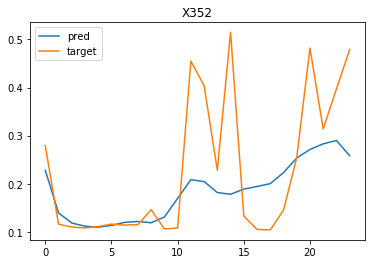

X352
finished in 0:05:27.358921


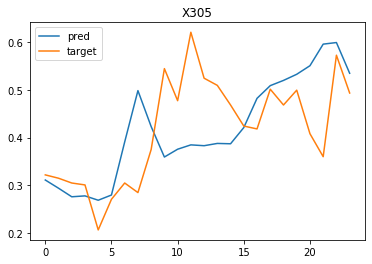

X305
finished in 0:05:26.747234


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


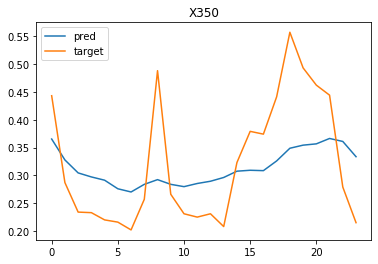

X350
finished in 0:06:28.279837


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


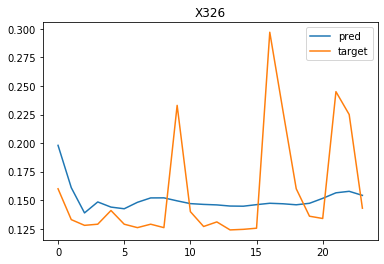

X326
finished in 0:09:21.224593


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))


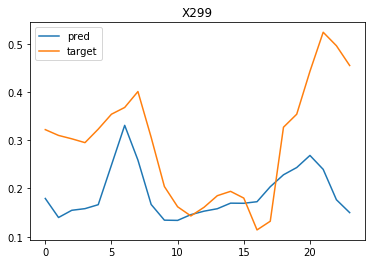

X299
finished in 0:09:14.801418


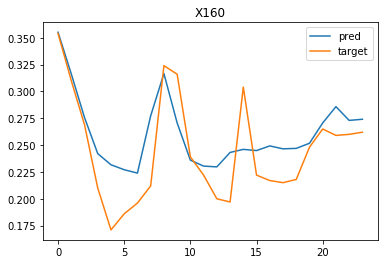

X160
finished in 0:07:25.932780


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


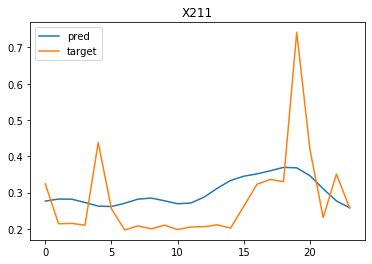

X211
finished in 0:09:14.617235


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tb

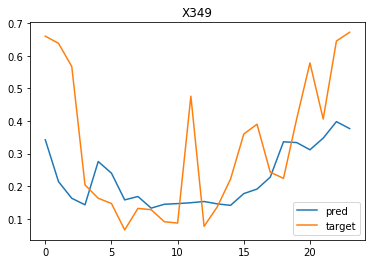

X349
finished in 0:05:56.766844


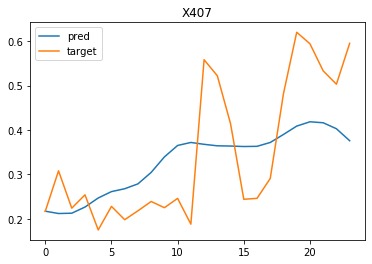

X407
finished in 0:10:04.800219


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


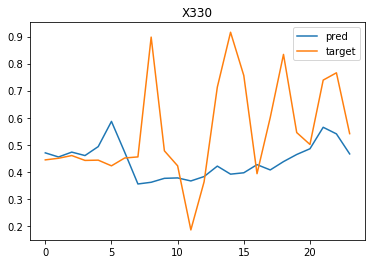

X330
finished in 0:09:28.292284


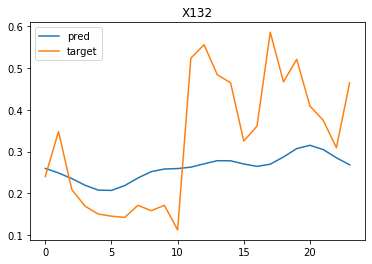

X132
finished in 0:07:00.524942


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))


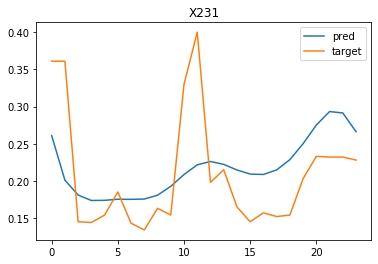

X231
finished in 0:07:08.722432


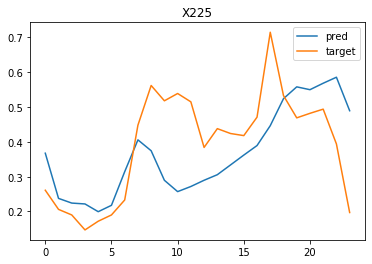

X225
finished in 0:09:14.600262


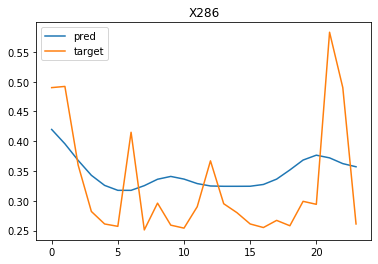

X286
finished in 0:06:11.556837


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
Process ForkPoolWorker-750:
Process ForkPoolWorker-749:
Traceback (most recent call last):
  File "/usr/lib/python

KeyboardInterrupt: ignored

  File "/usr/local/lib/python3.6/dist-packages/tbats/abstract/ParamsOptimizer.py", line 105, in optimize
    'fatol': 1e-8,
  File "/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py", line 588, in minimize
    return _minimize_neldermead(fun, x0, args, callback, **options)
  File "/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py", line 588, in minimize
    return _minimize_neldermead(fun, x0, args, callback, **options)
  File "/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py", line 602, in _minimize_neldermead
    fxr = func(xr)
  File "/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py", line 602, in _minimize_neldermead
    fxr = func(xr)
  File "/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py", line 327, in function_wrapper
    return function(*(wrapper_args + args))
  File "/usr/local/lib/python3.6/dist-packages/tbats/abstract/ParamsOptimizer.py", line 120, in _scale_and_calculate_likelihood
    re

In [0]:
from time import time

total_start_time = time()

agg={}
for key in ['X303', 'X241', 'X435', 'X402', 'X352', 'X305', 'X350', 'X326', 'X299', 'X160', 'X211', 'X349', 'X407', 'X330', 'X132', 'X231', 'X225', 'X286', 'X354', 'X353', 'X255', 'X393', 'X157', 
        'X323', 'X130', 'X269', 'X172', 'X289', 'X216', 'X398', 'X233', 'X214', 'X270', 'X371', 'X200', 'X163']: # 미터ID 200개의 리스트를 unique()함수를 통해 추출합니다.
    temp = sun3.loc[sun3['place_id']==key] # 미터ID 하나를 할당합니다.

    a = pd.DataFrame() # a라는 데이터프레임에 예측값을 정리합니다
    start_time = time()
# 시간별 예측

    estimator = TBATS(seasonal_periods=(24, 168))
    model = estimator.fit(temp['target'])
    # Forecast 24 hours ahead 
    fcst = model.forecast(steps=24)
    
    for i in range(24):
        a['X2018_7_1_'+str(i+1)+'h']=[fcst[i]] # column명을 submission 형태에 맞게 지정합니다.
        a['X2018_7_1_'+str(i+1)+'h'] = np.where(a['X2018_7_1_'+str(i+1)+'h']<0, temp['target'].min(), a['X2018_7_1_'+str(i+1)+'h'])

    # 그래프
    plt.plot(range(0,24),a[a.columns[0:24]].iloc[0], label='pred')
    plt.plot(range(0,24),X_test[key],label='target')
    plt.legend()
    plt.title(key)
    plt.show()
    
    for i in range(10):
        a['X2018_7_'+str(i+1)+'_d']= 0
    
    # 월별 예측
    # 일별로 예측하여 7월 ~ 11월의 일 수에 맞게 나누어 합산합니다.
    a['X2018_7_m'] = 0 # 7월 
    a['X2018_8_m'] = 0 # 8월
    a['X2018_9_m'] = 0 # 9월
    a['X2018_10_m'] = 0 # 10월
    a['X2018_11_m'] = 0 # 11월
    
    a['meter_id'] = key 
    agg[key] = a[submission.columns.tolist()]
    print(key)

    #print(key, ' : ',results_ARIMA.aic, ' , ')
    print('finished in {}'.format(str(datetime.timedelta(seconds=time() - start_time))))
print('complited in {}'.format(str(datetime.timedelta(seconds=time() - total_start_time))))
print('---- Modeling Done ----')

In [0]:
TBATS_31 = pd.concat(agg, ignore_index=False)
TBATS_32 = TBATS_31.reset_index().drop(['level_0','level_1'], axis=1)
TBATS_32['id'] = TBATS_22['meter_id'].str.replace('X','').astype(int)
TBATS_32 =  TBATS_32.sort_values(by='id', ascending=True).drop(['id'], axis=1).reset_index(drop=True)

In [0]:
TBATS_32

,meter_id,X2018_7_1_1h,X2018_7_1_2h,X2018_7_1_3h,X2018_7_1_4h,X2018_7_1_5h,X2018_7_1_6h,X2018_7_1_7h,X2018_7_1_8h,X2018_7_1_9h,X2018_7_1_10h,X2018_7_1_11h,X2018_7_1_12h,X2018_7_1_13h,X2018_7_1_14h,X2018_7_1_15h,X2018_7_1_16h,X2018_7_1_17h,X2018_7_1_18h,X2018_7_1_19h,X2018_7_1_20h,X2018_7_1_21h,X2018_7_1_22h,X2018_7_1_23h,X2018_7_1_24h,X2018_7_1_d,X2018_7_2_d,X2018_7_3_d,X2018_7_4_d,X2018_7_5_d,X2018_7_6_d,X2018_7_7_d,X2018_7_8_d,X2018_7_9_d,X2018_7_10_d,X2018_7_m,X2018_8_m,X2018_9_m,X2018_10_m,X2018_11_m
0,X303,0.550019,0.457569,0.391017,0.322881,0.279178,0.277822,0.322277,0.391459,0.437994,0.437400,0.412248,0.388862,0.375756,0.377140,0.400838,0.448641,0.505395,0.551278,0.591184,0.646983,0.710971,0.728128,0.665126,0.570479,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,X241,0.230369,0.229507,0.222540,0.218076,0.235275,0.282514,0.336538,0.351730,0.316281,0.269860,0.249115,0.255327,0.265659,0.261074,0.247337,0.242629,0.255589,0.281257,0.308075,0.324116,0.319875,0.294376,0.260755,0.236721,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,X435,0.185891,0.191262,0.189260,0.194860,0.210951,0.212016,0.197670,0.202627,0.230516,0.236099,0.208526,0.199880,0.228182,0.244679,0.213007,0.180832,0.182556,0.199721,0.211485,0.238819,0.299298,0.346840,0.329782,0.289416,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,X402,0.239515,0.216626,0.210277,0.202426,0.210015,0.214846,0.239902,0.313585,0.338527,0.310523,0.364206,0.450977,0.431937,0.394855,0.367910,0.321997,0.334540,0.422265,0.457886,0.410525,0.417147,0.517542,0.541526,0.378582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,X352,0.228076,0.139350,0.118339,0.111671,0.109561,0.113397,0.119727,0.121547,0.118881,0.130936,0.169607,0.208423,0.204503,0.181685,0.178109,0.188881,0.194246,0.200257,0.223103,0.253489,0.271276,0.282917,0.289910,0.258266,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,X305,0.311262,0.294138,0.276235,0.278100,0.269016,0.279927,0.390830,0.498033,0.422927,0.359292,0.375588,0.384684,0.382941,0.387692,0.386977,0.420832,0.481894,0.508446,0.519347,0.532175,0.550081,0.595155,0.598479,0.534294,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,X350,0.365229,0.327685,0.304389,0.297151,0.291292,0.275896,0.270139,0.283836,0.292297,0.283842,0.279699,0.285365,0.289410,0.296173,0.307474,0.309131,0.308443,0.325888,0.348662,0.354228,0.356554,0.366231,0.360878,0.333496,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,X326,0.198008,0.160962,0.138884,0.148483,0.143970,0.142519,0.148162,0.152003,0.152059,0.149436,0.147014,0.146335,0.145891,0.144893,0.144753,0.146113,0.147320,0.146877,0.145989,0.147297,0.151625,0.156468,0.157783,0.154236,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,X299,0.179235,0.139756,0.154702,0.158124,0.166319,0.248509,0.330891,0.258838,0.166802,0.134232,0.133758,0.145669,0.152900,0.157951,0.169502,0.169233,0.172514,0.203568,0.228351,0.243388,0.268489,0.239594,0.176579,0.149873,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,X160,0.355087,0.316288,0.275647,0.242041,0.231665,0.227067,0.223906,0.277256,0.316628,0.270648,0.235980,0.230432,0.229710,0.243137,0.246004,0.244906,0.249229,0.246505,0.246932,0.251713,0.270635,0.285799,0.272991,0.274053,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
TBATS_32.to_csv('/content/drive/My Drive/dacon/Tbats_n_X286.csv', index=False)

X276부터 X312

/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


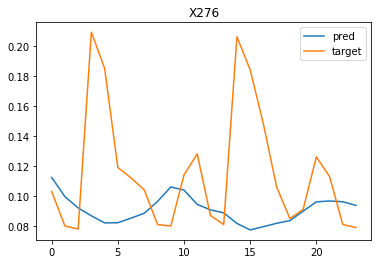

X276
finished in 0:10:00.637079


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


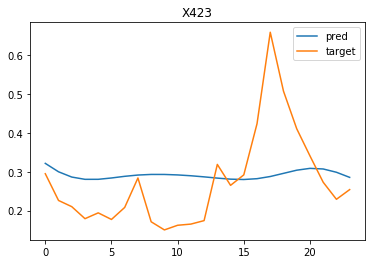

X423
finished in 0:06:57.332625


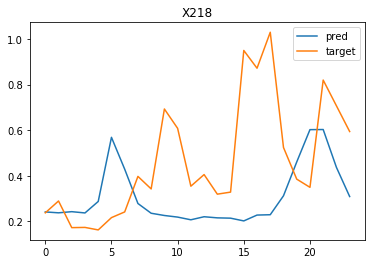

X218
finished in 0:07:39.466380


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in 

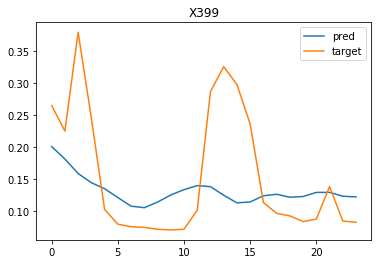

X399
finished in 0:05:54.137821


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/loca

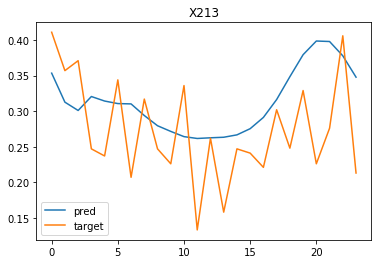

X213
finished in 0:10:04.722142


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tb

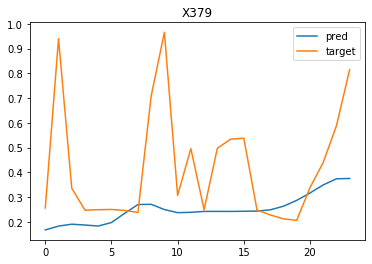

X379
finished in 0:06:27.000348


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


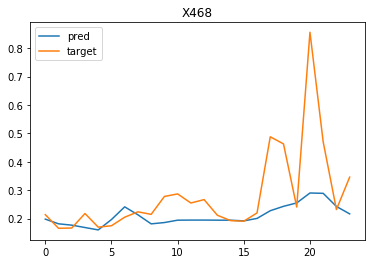

X468
finished in 0:09:38.091331


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tb

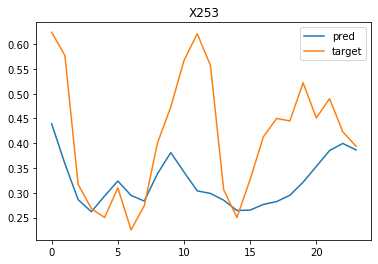

X253
finished in 0:09:42.550574


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/loca

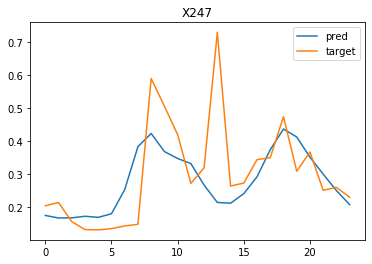

X247
finished in 0:05:53.455363


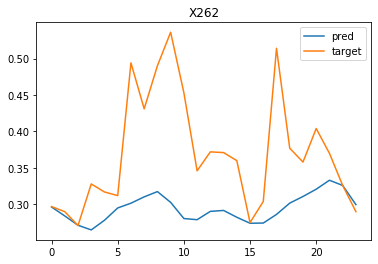

X262
finished in 0:10:33.246998


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


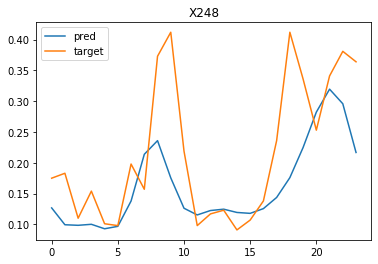

X248
finished in 0:04:57.930690


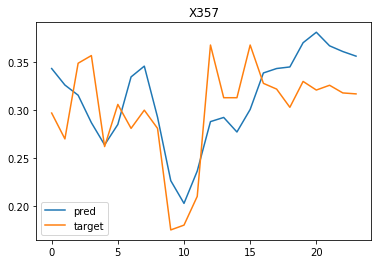

X357
finished in 0:07:13.236209


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/loca

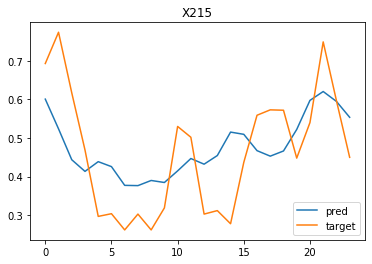

X215
finished in 0:05:29.333939


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))


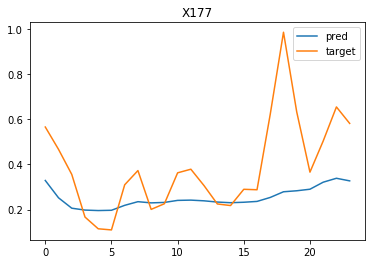

X177
finished in 0:07:59.042721


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))


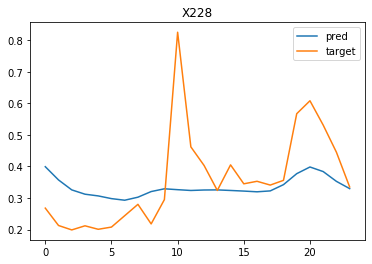

X228
finished in 0:08:06.665465


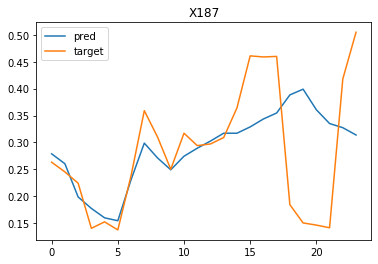

X187
finished in 0:10:08.507152


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


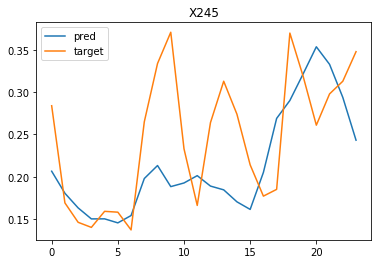

X245
finished in 0:06:01.420509


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


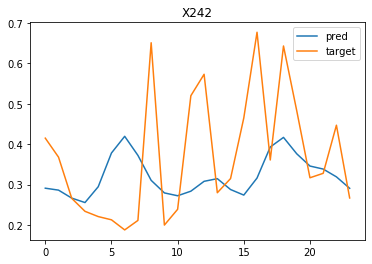

X242
finished in 0:06:31.659115


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tb

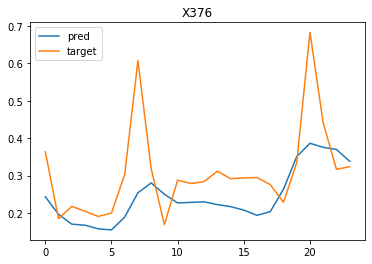

X376
finished in 0:06:44.425708


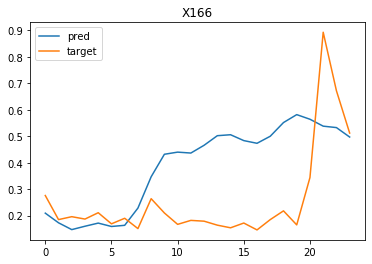

X166
finished in 0:08:23.917020


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tb

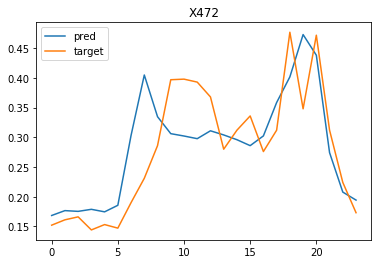

X472
finished in 0:11:28.929646


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tb

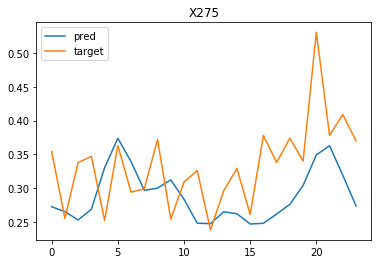

X275
finished in 0:05:08.232658


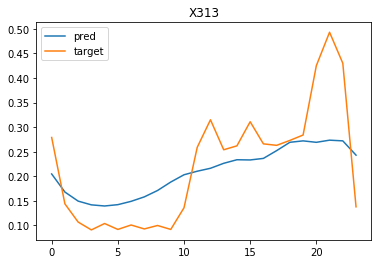

X313
finished in 0:05:36.124117


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))


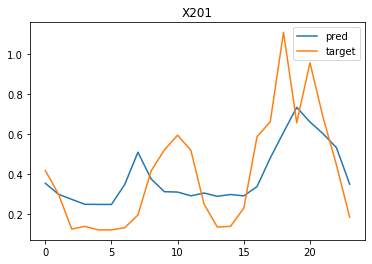

X201
finished in 0:11:42.191713


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


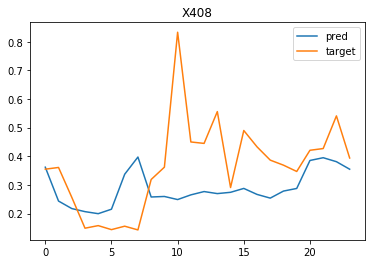

X408
finished in 0:09:38.525623


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tb

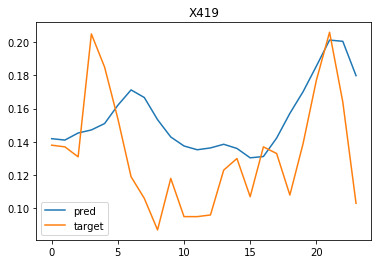

X419
finished in 0:05:20.668877


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


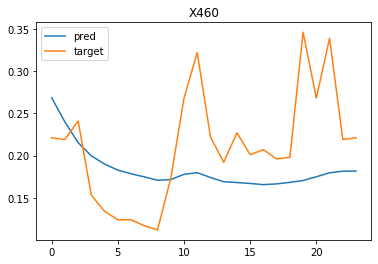

X460
finished in 0:08:45.354526


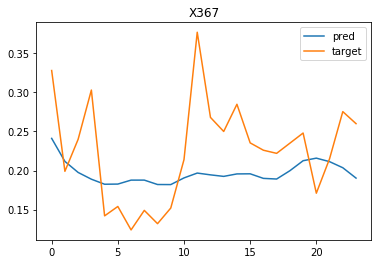

X367
finished in 0:06:15.699028


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


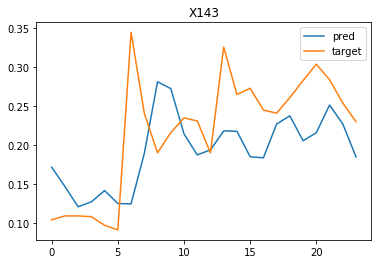

X143
finished in 0:07:12.797339


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) 

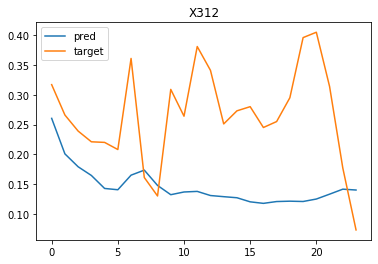

X312
finished in 0:08:38.997018
complited in 3:54:14.687781
---- Modeling Done ----


In [0]:
from time import time

total_start_time = time()

agg={}
for key in ['X276', 'X423', 'X218', 'X399', 'X213', 'X379', 'X468', 'X253', 'X247', 'X262', 'X248', 'X357', 
        'X215', 'X177', 'X228', 'X187', 'X245', 'X242', 'X376', 'X166', 'X472', 'X275', 'X313', 'X201', 'X408', 'X419', 'X460', 'X367', 'X143', 'X312']: # 미터ID 200개의 리스트를 unique()함수를 통해 추출합니다.
    temp = sun3.loc[sun3['place_id']==key] # 미터ID 하나를 할당합니다.

    a = pd.DataFrame() # a라는 데이터프레임에 예측값을 정리합니다
    start_time = time()
# 시간별 예측

    estimator = TBATS(seasonal_periods=(24, 168))
    model = estimator.fit(temp['target'])
    # Forecast 24 hours ahead 
    fcst = model.forecast(steps=24)
    
    for i in range(24):
        a['X2018_7_1_'+str(i+1)+'h']=[fcst[i]] # column명을 submission 형태에 맞게 지정합니다.
        a['X2018_7_1_'+str(i+1)+'h'] = np.where(a['X2018_7_1_'+str(i+1)+'h']<0, temp['target'].min(), a['X2018_7_1_'+str(i+1)+'h'])

    # 그래프
    plt.plot(range(0,24),a[a.columns[0:24]].iloc[0], label='pred')
    plt.plot(range(0,24),X_test[key],label='target')
    plt.legend()
    plt.title(key)
    plt.show()
    
    for i in range(10):
        a['X2018_7_'+str(i+1)+'_d']= 0
    
    # 월별 예측
    # 일별로 예측하여 7월 ~ 11월의 일 수에 맞게 나누어 합산합니다.
    a['X2018_7_m'] = 0 # 7월 
    a['X2018_8_m'] = 0 # 8월
    a['X2018_9_m'] = 0 # 9월
    a['X2018_10_m'] = 0 # 10월
    a['X2018_11_m'] = 0 # 11월
    
    a['meter_id'] = key 
    agg[key] = a[submission.columns.tolist()]
    print(key)

    #print(key, ' : ',results_ARIMA.aic, ' , ')
    print('finished in {}'.format(str(datetime.timedelta(seconds=time() - start_time))))
print('complited in {}'.format(str(datetime.timedelta(seconds=time() - total_start_time))))
print('---- Modeling Done ----')

In [0]:
TBATS_41 = pd.concat(agg, ignore_index=False)
TBATS_42 = TBATS_41.reset_index().drop(['level_0','level_1'], axis=1)
TBATS_42['id'] = TBATS_42['meter_id'].str.replace('X','').astype(int)
TBATS_42 =  TBATS_42.sort_values(by='id', ascending=True).drop(['id'], axis=1).reset_index(drop=True)

In [0]:
TBATS_42.to_csv('/content/drive/My Drive/dacon/Tbats_n_X276X312.csv', index=False)

'X403', 'X341', 'X149', 'X377', 'X232', 'X333', 'X140', 'X422', 'X386', 'X250', 'X142', 'X235', 'X446', 'X331', 'X186', 'X243', 'X194', 'X183', 'X139', 'X459', 'X457', 'X368', 'X282', 'X426', 
        'X192', 'X283', 'X329', 'X223', 'X266', 'X443', 'X347', 'X230', 'X155','X481'

/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


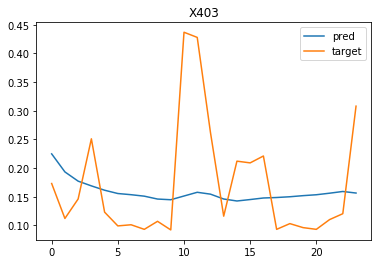

X403
finished in 0:10:54.978112


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))


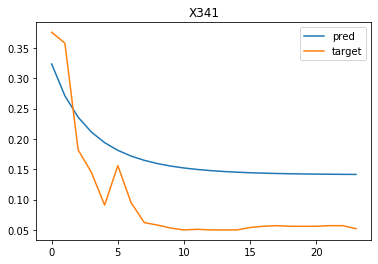

X341
finished in 0:08:01.998559


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tb

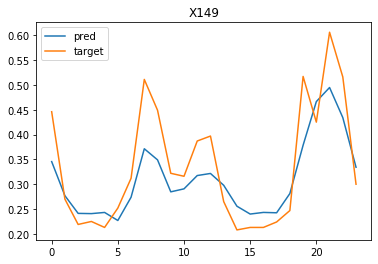

X149
finished in 0:14:02.237959


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


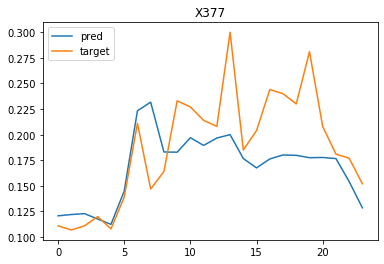

X377
finished in 0:11:50.537204


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


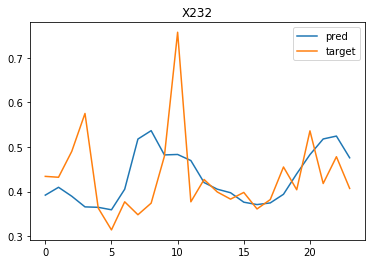

X232
finished in 0:08:44.964350


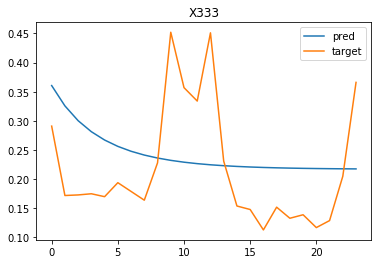

X333
finished in 0:16:08.269785


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tb

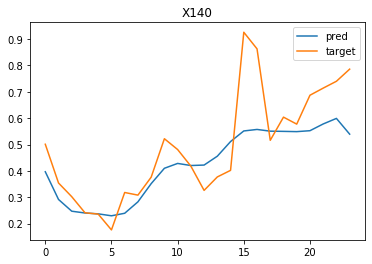

X140
finished in 0:09:49.827931


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))


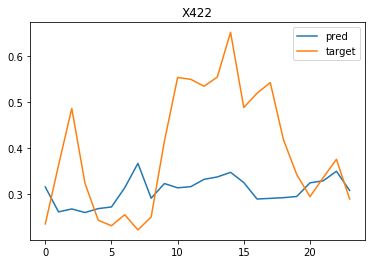

X422
finished in 0:11:38.993331


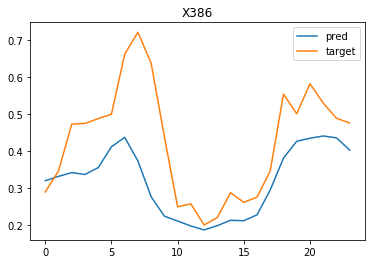

X386
finished in 0:13:42.063544


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


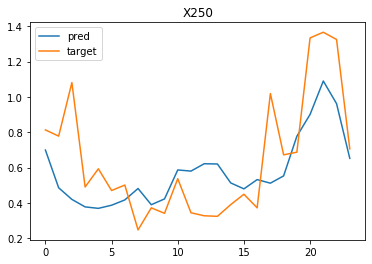

X250
finished in 0:10:25.917095


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))


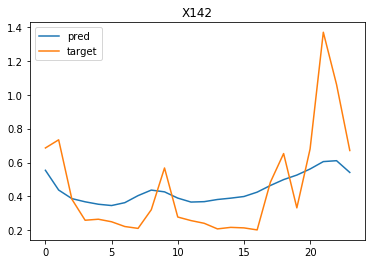

X142
finished in 0:08:58.882413


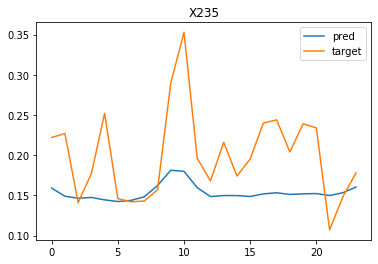

X235
finished in 0:10:37.908603


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


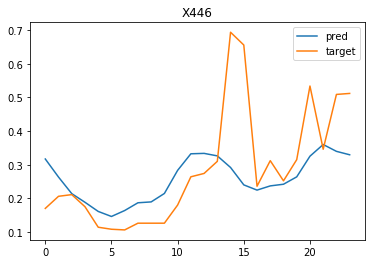

X446
finished in 0:13:36.424773


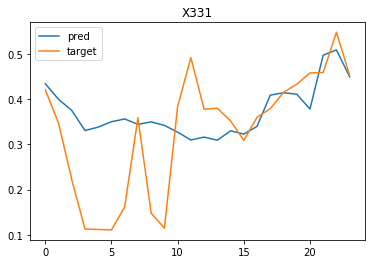

X331
finished in 0:14:16.389934


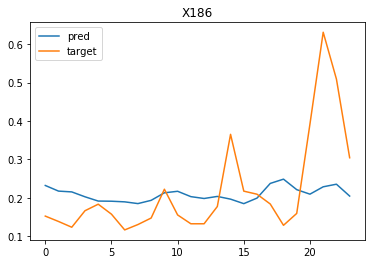

X186
finished in 0:08:42.971779


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


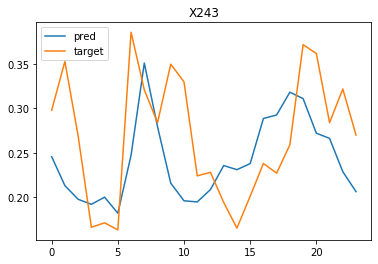

X243
finished in 0:12:26.864795


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


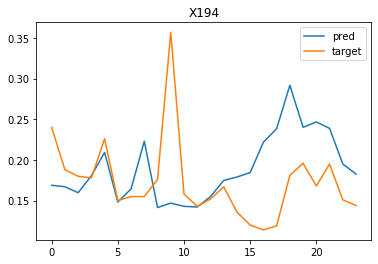

X194
finished in 0:08:56.854322


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tb

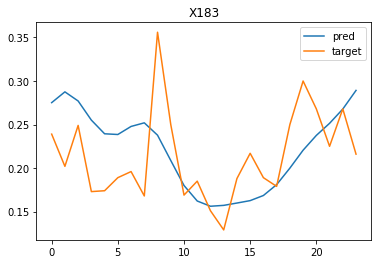

X183
finished in 0:09:46.775021


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


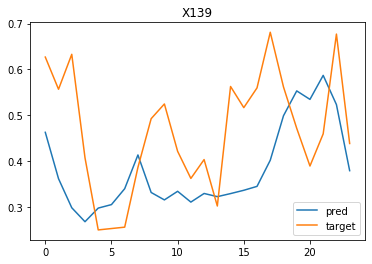

X139
finished in 0:14:26.167948


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


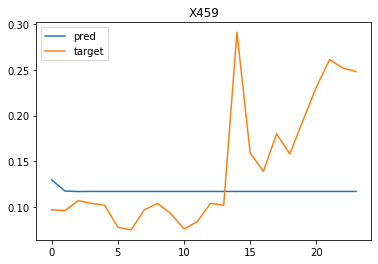

X459
finished in 0:09:23.079337


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


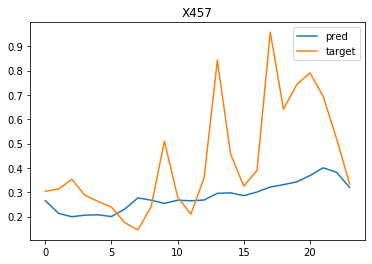

X457
finished in 0:12:52.683917


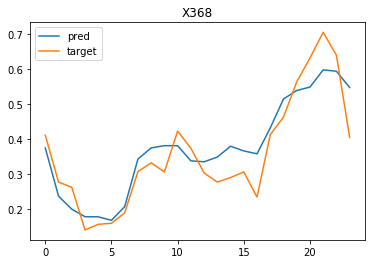

X368
finished in 0:12:31.076346


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tb

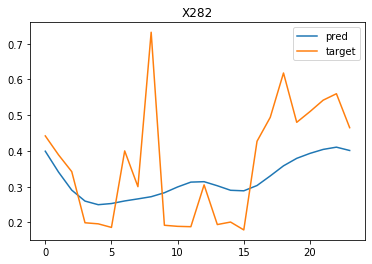

X282
finished in 0:07:05.307018


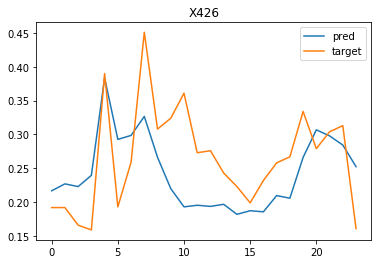

X426
finished in 0:07:58.410379


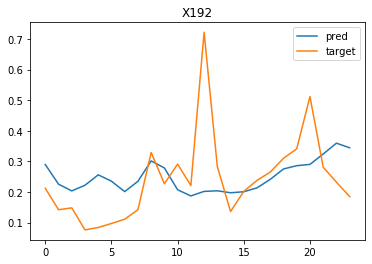

X192
finished in 0:07:10.047669


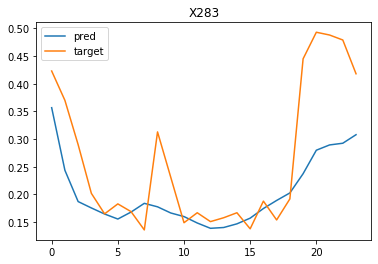

X283
finished in 0:08:31.942474


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))


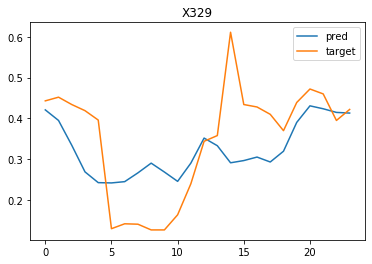

X329
finished in 0:15:45.677890


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


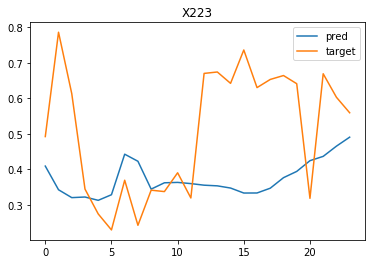

X223
finished in 0:13:53.288534


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


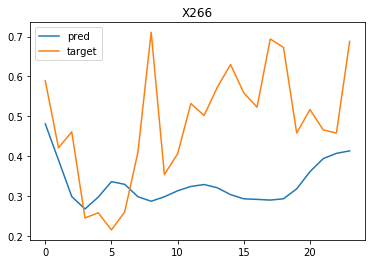

X266
finished in 0:08:40.023393


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


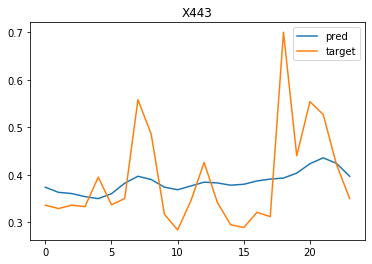

X443
finished in 0:20:54.395311


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)


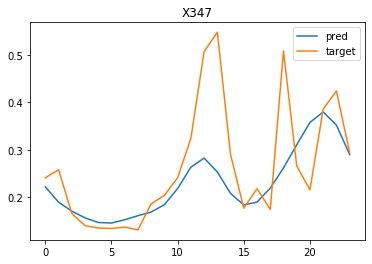

X347
finished in 0:18:53.176093


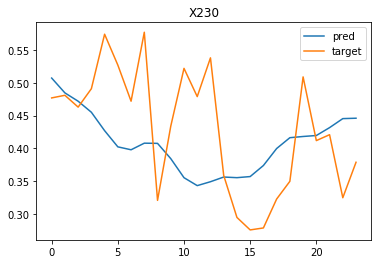

X230
finished in 0:08:32.324340


/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np.abs(yy) ** (1 / lam))
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:36: RuntimeWarning: overflow encountered in exp
  return np.exp(y)
/usr/local/lib/python3.6/dist-packages/tbats/transformation/BoxCox.py:38: RuntimeWarning: overflow encountered in power
  return np.sign(yy) * (np

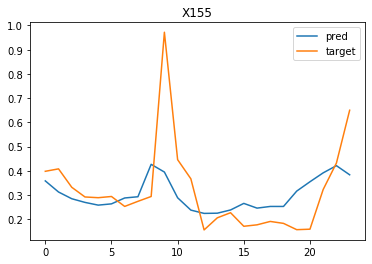

X155
finished in 0:12:51.099391


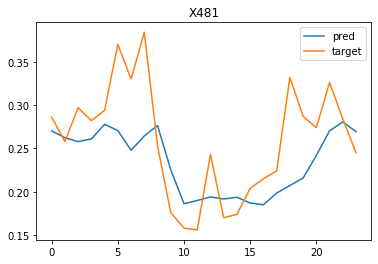

X481
finished in 0:08:36.815029
complited in 6:30:48.939076
---- Modeling Done ----


In [0]:
from time import time

total_start_time = time()

agg={}
for key in ['X403', 'X341', 'X149', 'X377', 'X232', 'X333', 'X140', 'X422', 'X386', 'X250', 'X142', 'X235', 'X446', 'X331', 'X186', 'X243', 'X194', 'X183', 'X139', 'X459', 'X457', 'X368', 'X282', 'X426', 
        'X192', 'X283', 'X329', 'X223', 'X266', 'X443', 'X347', 'X230', 'X155','X481']: # 미터ID 200개의 리스트를 unique()함수를 통해 추출합니다.
    temp = sun3.loc[sun3['place_id']==key] # 미터ID 하나를 할당합니다.

    a = pd.DataFrame() # a라는 데이터프레임에 예측값을 정리합니다
    start_time = time()
# 시간별 예측

    estimator = TBATS(seasonal_periods=(24, 168))
    model = estimator.fit(temp['target'])
    # Forecast 24 hours ahead 
    fcst = model.forecast(steps=24)
    
    for i in range(24):
        a['X2018_7_1_'+str(i+1)+'h']=[fcst[i]] # column명을 submission 형태에 맞게 지정합니다.
        a['X2018_7_1_'+str(i+1)+'h'] = np.where(a['X2018_7_1_'+str(i+1)+'h']<0, temp['target'].min(), a['X2018_7_1_'+str(i+1)+'h'])

    # 그래프
    plt.plot(range(0,24),a[a.columns[0:24]].iloc[0], label='pred')
    plt.plot(range(0,24),X_test[key],label='target')
    plt.legend()
    plt.title(key)
    plt.show()
    
    for i in range(10):
        a['X2018_7_'+str(i+1)+'_d']= 0
    
    # 월별 예측
    # 일별로 예측하여 7월 ~ 11월의 일 수에 맞게 나누어 합산합니다.
    a['X2018_7_m'] = 0 # 7월 
    a['X2018_8_m'] = 0 # 8월
    a['X2018_9_m'] = 0 # 9월
    a['X2018_10_m'] = 0 # 10월
    a['X2018_11_m'] = 0 # 11월
    
    a['meter_id'] = key 
    agg[key] = a[submission.columns.tolist()]
    print(key)

    #print(key, ' : ',results_ARIMA.aic, ' , ')
    print('finished in {}'.format(str(datetime.timedelta(seconds=time() - start_time))))
print('complited in {}'.format(str(datetime.timedelta(seconds=time() - total_start_time))))
print('---- Modeling Done ----')

In [0]:
TBATS_41 = pd.concat(agg, ignore_index=False)
TBATS_42 = TBATS_41.reset_index().drop(['level_0','level_1'], axis=1)
TBATS_42['id'] = TBATS_42['meter_id'].str.replace('X','').astype(int)
TBATS_42 =  TBATS_42.sort_values(by='id', ascending=True).drop(['id'], axis=1).reset_index(drop=True)
TBATS_42.to_csv('/content/drive/My Drive/dacon/Tbats_n_403X481.csv', index=False)